## <center> Bank Marketing Analysis </center> 

<center>by Runtian Li, Rafe Chang, Sid Grover, Anu Banga </center>

**Repo Link:** https://github.com/UBC-MDS/dsci_522_group_8.git

In [1]:
## Import necessary Packages
import pandas as pd
import numpy as np
import statistics
import os
import sys

import altair as alt
alt.data_transformers.enable("vegafusion")

import warnings
warnings.filterwarnings("ignore")

sys.path.append("code/.")

# Machine Learning
import IPython
from IPython.display import HTML, display, Image

# from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay, classification_report, PrecisionRecallDisplay
from scipy.stats import uniform


# %matplotlib inline
pd.set_option("display.max_colwidth", 200)

## <center> Summary </center>
Here we build a model of balanced SVC to try to predict if a new client will subscribe to a term deposit. We tested five different classification models, including dummy classifier, unbalanced/balanced logistic regression, and unbalanced/balanced SVC, and chose the optimal model of balanced SVC based on how the model scored on the test data; the model has the highest test recall score of 0.82, which indicates that the model makes the least false negative predictions among all five models. 

The balanced support vector machines model considers 13 different numerical/ categorical features of customers. After hyperparameter optimization, the model's test accuracy increased from 0.82 to 0.875. The results were somewhat expected, given SVC's known efficacy in classification tasks, particularly when there's a clear margin of separation. The high recall score of 0.875 indicates that the model is particularly adept at identifying clients likely to subscribe, which was the primary goal. It's noteworthy that such a high recall was achieved, as it suggests the model is highly sensitive to true positive cases.

## <center> Introduction </center>

### Background
The data set Bank Marketing was created by Sérgio Moro and Paulo Rita at the University Institute of Lisbon, and Paulo Cortez at the University of Minhom. It is sourced from the UCI Machine Learning Repository. Each row in this data set is an observation related to direct marketing campaigns (phone calls) of a Portuguese banking institution.

### Research Question

We are working on a binary classification model. The classification goal is to predict if the client will subscribe a term deposit: "yes" for will subscribe and "no" for won't subscribe.

### Data Description
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. It was sourced from the UCI Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/dataset/222/bank+marketing). We will be using bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 

These are the detail of all inputs:

| Feature Name | Type        | Description                                                                                   | Classes |
|--------------|-------------|-----------------------------------------------------------------------------------------------|---------|
| age          | Numeric     |                                                                                               |         |
| job          | Categorical | Type of job                                                                                   | 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown' |
| marital      | Categorical | Marital status                                                                                | 'divorced','married','single','unknown' |
| education    | Categorical |                                                                                               | 'primary', 'secondary', 'tertiary', 'unknown' |
| default      | Categorical | Has credit in default?                                                                        | 'no', 'yes', 'unknown' |
| housing      | Categorical | Has housing loan?                                                                             | 'no', 'yes', 'unknown' |
| loan         | Categorical | Has personal loan?                                                                            | 'no', 'yes', 'unknown' |
| balance      | Numeric     | Balance of the individual                                                                     |         |
| contact      | Categorical | Contact communication type                                                                    | 'cellular', 'telephone' |
| month        | Categorical | Last contact month of year                                                                    | 'jan', 'feb', 'mar', ..., 'nov', 'dec' |
| day          | Categorical | Last contact day of the week                                                                  | 'mon', 'tue', 'wed', 'thu', 'fri' |
| duration     | Numeric     | Last contact duration, in seconds                                                             |         |
| campaign     | Numeric     | Number of contacts performed during this campaign and for this client                        |         |
| pdays        | Numeric     | Number of days that passed by after the client was last contacted from a previous campaign    |         |
| previous     | Numeric     | Number of contacts performed before this campaign and for this client                         |         |
| poutcome     | Categorical | Outcome of the previous marketing campaign                                                    | 'failure', 'nonexistent', 'success' |
| y            | Binary      | Has the client subscribed to a term deposit?                                                  | 'yes', 'no' |


The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

## <center>Results and Discussion </center>

### Exploratory Data Analysis 

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Import the uniques function from the src folder
sys.path.append('..')
from src.uniques import get_uniques

df = pd.read_csv("../data/bank-full.csv", delimiter=";")
df.rename(columns={"y": "target"}, inplace=True)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

get_uniques(df);

In [3]:
# Import the eda_plotting functions function from the src folder
sys.path.append('..')
from src.eda_plotting import (
                                EDA_plot, 
                                spearman_correlation_matrix, 
                                text_EDA
                             )

In [4]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "poutcome"]
numerical_cols = numeric_cols

In [5]:
text_EDA(train_df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 28686 to 15725
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  target     36168 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.0+ MB


""



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
age,36168.0,40.944979,10.609908,18.0,33.0,39.0,48.00,95.0
balance,36168.0,1371.354208,2999.155128,-8019.0,73.0,448.5,1448.00,98417.0
day,36168.0,15.801095,8.309679,1.0,8.0,16.0,21.00,31.0
duration,36168.0,258.955403,259.218884,0.0,103.0,180.0,319.25,4918.0
campaign,36168.0,2.759013,3.095290,1.0,1.0,2.0,3.00,58.0
pdays,36168.0,40.199762,100.114274,-1.0,-1.0,-1.0,-1.00,871.0
previous,36168.0,0.580596,2.364362,0.0,0.0,0.0,0.00,275.0



First 5 Rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
28686,29,services,single,secondary,no,-205,no,no,cellular,30,jan,194,1,-1,0,unknown,no
9304,53,blue-collar,married,primary,no,0,yes,no,unknown,5,jun,285,2,-1,0,unknown,no
41425,55,management,married,primary,no,2587,no,no,cellular,4,sep,328,2,94,2,success,yes
44803,30,technician,single,tertiary,no,0,no,no,cellular,15,sep,214,2,-1,0,unknown,no
5878,30,unemployed,married,secondary,no,529,yes,yes,unknown,26,may,107,3,-1,0,unknown,no



Last 5 Rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
7763,50,unemployed,married,secondary,no,3674,yes,no,unknown,30,may,886,3,-1,0,unknown,yes
15377,36,management,married,tertiary,no,635,yes,no,cellular,18,jul,359,1,-1,0,unknown,no
17730,43,blue-collar,married,primary,no,3664,no,no,telephone,29,jul,274,1,-1,0,unknown,no
28030,55,unemployed,married,primary,no,8585,no,no,telephone,28,jan,201,2,-1,0,unknown,no
15725,46,management,single,tertiary,no,2154,yes,no,cellular,21,jul,87,4,-1,0,unknown,no


In [6]:
display(spearman_correlation_matrix(df, numerical_cols))

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.096380,-0.008948,-0.033257,0.037136,-0.017468,-0.011900
balance,0.096380,1.000000,0.001329,0.042651,-0.030959,0.069676,0.079536
day,-0.008948,0.001329,1.000000,-0.058142,0.139581,-0.092226,-0.087780
duration,-0.033257,0.042651,-0.058142,1.000000,-0.107962,0.028698,0.031175
campaign,0.037136,-0.030959,0.139581,-0.107962,1.000000,-0.112284,-0.108448
pdays,-0.017468,0.069676,-0.092226,0.028698,-0.112284,1.000000,0.985645
previous,-0.011900,0.079536,-0.087780,0.031175,-0.108448,0.985645,1.000000


In [7]:

display(EDA_plot(df, numeric_cols, categorical_cols))

alt.RepeatChart(...)

alt.RepeatChart(...)

(None, None)

### Preprocessing

<div class="alert alert-info">
    
- Since there is no missing values in our dataset, we don't need to do imputation or drop NAs.   
- We are going to drop "contact", "day" and "month" column here since they are not helping us in identifying useful underlying pattern in the model.    
- We take "age", "balance", "duration", "campaign", "pdays", "previous" as numerical features and we are doing StandardScaler transformation on them.
- We take "job", "marital", "education", "default", "housing", "loan", "poutcome" as categorical features and we are doing one hot encoding on them. We dropped columns only if the categorical is binary.
    
</div>

In [8]:
numeric_looking_columns = train_df.select_dtypes(include=np.number).columns.tolist()
print(numeric_looking_columns)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [9]:
# Lists of feature names
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "poutcome"]
drop_features = ["contact", "day", "month"]

In [10]:
# Import the count_classes function from the src folder
sys.path.append('..')
from src.preprocessor import preprocess_data

In [11]:
# Call the funciton preprocess_data 
X_train_enc, X_train, y_train, X_test, y_test, preprocessor = preprocess_data(
    train_df, test_df, numerical_features, categorical_features, drop_features, "target")
X_train_enc.head()

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
28686,-1.125848,-0.525607,-0.250585,-0.568295,-0.411533,-0.245565,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9304,1.136220,-0.457253,0.100475,-0.245219,-0.411533,-0.245565,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41425,1.324725,0.405335,0.266360,-0.245219,0.537396,0.600341,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44803,-1.031595,-0.457253,-0.173429,-0.245219,-0.411533,-0.245565,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5878,-1.031595,-0.280868,-0.586213,0.077857,-0.411533,-0.245565,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### Model Selection

In [12]:
# 1. Base Model: Dummy Classifier
classification_metrics = ["accuracy", "precision", "recall", "f1"]
dc = DummyClassifier(strategy="most_frequent")
pipe_dc = make_pipeline(preprocessor, dc)
# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results = {}
scoring = {
    "accuracy": 'accuracy',
    'precision': make_scorer(precision_score, pos_label="yes", zero_division=0),
    'recall': make_scorer(recall_score, pos_label="yes"),
    'f1': make_scorer(f1_score, pos_label="yes")
}  # scoring can be a string, a list, or a dictionary

cross_val_results['dummy'] = pd.DataFrame(cross_validate(pipe_dc, X_train, y_train, return_train_score=True, scoring=scoring)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['dummy']

,mean,std
fit_time,0.042,0.001
score_time,0.086,0.002
test_accuracy,0.883,0.000
train_accuracy,0.883,0.000
test_precision,0.000,0.000
train_precision,0.000,0.000
test_recall,0.000,0.000
train_recall,0.000,0.000
test_f1,0.000,0.000
train_f1,0.000,0.000


In [13]:
# 2. Logistic regression

# The logreg model pipeline
logreg = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['logreg'] = pd.DataFrame(cross_validate(logreg, X_train, y_train, return_train_score=True, scoring=scoring)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg'] 

,mean,std
fit_time,0.132,0.005
score_time,0.100,0.001
test_accuracy,0.900,0.003
train_accuracy,0.900,0.001
test_precision,0.652,0.029
train_precision,0.655,0.006
test_recall,0.313,0.019
train_recall,0.315,0.009
test_f1,0.423,0.023
train_f1,0.425,0.009


In [14]:
# 3. Support vector classifier

# The svc model pipeline
svc = make_pipeline(preprocessor, SVC(random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['svc'] = pd.DataFrame(cross_validate(svc, X_train, y_train, return_train_score=True, scoring=scoring)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['svc'] 

In [15]:
# 4. Balanced logistic regression
logreg_bal = make_pipeline(preprocessor, 
                           LogisticRegression(max_iter=1000, 
                                              random_state=123, 
                                              class_weight="balanced"))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['logreg_bal'] = pd.DataFrame(cross_validate(logreg_bal, X_train, y_train, return_train_score=True, scoring=scoring)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg_bal'] 

,mean,std
fit_time,0.894,0.197
score_time,0.195,0.050
test_accuracy,0.829,0.002
train_accuracy,0.829,0.001
test_precision,0.386,0.005
train_precision,0.386,0.003
test_recall,0.777,0.012
train_recall,0.778,0.002
test_f1,0.516,0.006
train_f1,0.516,0.003


In [16]:
# 5. Balanced support vector classifier
svc_bal = make_pipeline(preprocessor, SVC(random_state=123, class_weight="balanced"))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['svc_bal'] = pd.DataFrame(cross_validate(svc_bal, X_train, y_train, return_train_score=True, scoring=scoring)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['svc_bal'] 

,mean,std
fit_time,11.606,0.144
score_time,4.384,0.028
test_accuracy,0.814,0.006
train_accuracy,0.825,0.001
test_precision,0.368,0.010
train_precision,0.388,0.001
test_recall,0.821,0.011
train_recall,0.864,0.004
test_f1,0.508,0.011
train_f1,0.535,0.001


In [17]:
# Compare the average scores of all the models
pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    
    level=1
).style.format(
    precision=2
).background_gradient(
    axis=None
)

,dummy,logreg,svc,logreg_bal,svc_bal
fit_time,0.06,0.81,6.46,0.89,11.61
score_time,0.09,0.17,2.44,0.20,4.38
test_accuracy,0.88,0.90,0.90,0.83,0.81
train_accuracy,0.88,0.90,0.91,0.83,0.82
test_precision,0.00,0.65,0.66,0.39,0.37
train_precision,0.00,0.66,0.73,0.39,0.39
test_recall,0.00,0.31,0.29,0.78,0.82
train_recall,0.00,0.32,0.33,0.78,0.86
test_f1,0.00,0.42,0.40,0.52,0.51
train_f1,0.00,0.42,0.45,0.52,0.54


<div class="alert alert-info">

`Dummy Classifier` has low accuracy and zero precision, recall, and F1 scores, indicating it never predicts the positive class (in this case the client subscribed a term deposit). This is expected as it always predicts the most frequent class.

`logreg` shows improved accuracy over the dummy model. However, its recall is low, suggesting it misses a significant number of true positive cases. `svc` performed almost the same as logistic regression model among all metrics.

`logreg_bal` and `svc_bal` have lower accuracy compared to their unbalanced counterparts but significantly higher recall. This indicates they are better at identifying positive cases but at the cost of making more false positive errors.

Given the context of our bank marketing data set, we aim to detect the clients who will subscribe a term deposit given the features. Missing a potential "yes" could be more costly than false positives, as it represents a lost opportunity for the sales team to transform this potential customer. Therefore, we chose `svc_bal` as the model has the highest `test_recall` score. 
    
</div>

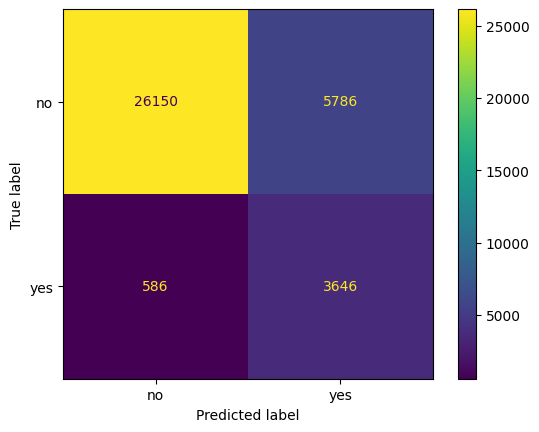

In [18]:
svc_bal.fit(X_train, y_train)
confmat_svc_bal = ConfusionMatrixDisplay.from_estimator(
    svc_bal,
    X_train,
    y_train,
    values_format="d",) 
confmat_svc_bal

In [19]:
# Import the scoring_metrics functions function from the src folder
sys.path.append('..')
from src.scoringmetrics import scoring_metrics
result=scoring_metrics(svc_bal, X_train, y_train, X_test, y_test, pos_label="yes")
result

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,fit_time,score_time
0,0.823822,0.815659,0.386556,0.369435,0.861531,0.816462,0.533665,0.508694,19.93594,32.581755


### Hyperparameter Optimization

<div class="alert alert-info">

Optimizing hyperparameters in SVC with a smaller sample size of 10,000 instances is a strategy aimed at enhancing computational efficiency. This approach expedites the exploration of hyperparameter possibilities, aiding in the discovery of potential configurations. While the outcomes validate the concept, it's crucial to recognize and manage the constraints stemming from the smaller dataset size when interpreting the results.
    
</div>

In [20]:
# Creating a sample of 10000 observations
sample_data = df.sample(n=10000, random_state=123)
train_df_sampled, test_df_sampled = train_test_split(sample_data, test_size=0.2, random_state=123)

X_train_sampled = train_df_sampled.drop(columns=["target"])
X_test_sampled = test_df_sampled.drop(columns=["target"])
y_train_sampled = train_df_sampled["target"]
y_test_sampled = test_df_sampled["target"]

# Transformation on the sample training data
sample_preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(drop="if_binary"), categorical_features),
    ("drop", drop_features),
)

# X_train_sampled_enc = pd.DataFrame(sample_preprocessor.fit_transform(X_train_sampled), index=X_train_sampled.index, columns=new_columns)

svc_bal_sample = make_pipeline(sample_preprocessor, SVC(random_state=123, class_weight="balanced"))

param_dist = {
    'svc__C': uniform(0.1, 10),
    'svc__gamma': uniform(0.001, 0.1),
    'svc__kernel': ['rbf', 'sigmoid', 'linear']
}

# Perform RandomizedSearchCV for hyperparameter optimization
random_search = RandomizedSearchCV(svc_bal_sample, param_distributions=param_dist, n_iter=25, cv=5, n_jobs=-1, random_state=123)
random_search.fit(X_train_sampled, y_train_sampled)

# Best hyperparameters
best_params_random = random_search.best_params_
print("Best Hyperparameters (Randomized Search):", best_params_random)

Best Hyperparameters (Randomized Search): {'svc__C': 4.331064601244609, 'svc__gamma': 0.09907641983846155, 'svc__kernel': 'rbf'}


In [21]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,3,3,3,7,7,9,10,...,16,17,18,19,20,21,22,23,24,25
mean_test_score,0.831875,0.82775,0.8275,0.8275,0.8275,0.8275,0.827375,0.827375,0.825,0.82125,...,0.819,0.819,0.818375,0.76425,0.742125,0.73775,0.732375,0.730375,0.71675,0.714125
param_svc__gamma,0.099076,0.008709,0.044086,0.073905,0.069326,0.018537,0.072915,0.012562,0.067931,0.054183,...,0.044342,0.040804,0.025367,0.023826,0.042702,0.042721,0.049303,0.052176,0.0776,0.083634
param_svc__C,4.331065,1.640822,4.437012,3.53178,5.073088,5.40062,7.008849,6.33953,5.204223,5.415514,...,2.927029,0.696779,7.736828,3.717887,3.141208,3.677289,2.604554,7.034032,9.979953,1.306287
mean_fit_time,0.677113,0.7783,1.51885,1.317613,1.537338,1.499696,1.95118,1.800268,0.688293,0.707351,...,0.756204,0.655976,0.770482,0.46971,0.565585,0.652933,0.59485,0.525791,0.603188,0.615842


### Test results after hyperparameter optimization

In [22]:
# Evaluate the best model on the test set
best_model_random = random_search.best_estimator_
accuracy_random = best_model_random.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy_random)

Accuracy on Test Set: 0.8613292049098751


In [23]:
predictions = best_model_random.predict(X_test)

recall = recall_score(y_test, predictions, pos_label='yes')
print("Recall on Test Set:", recall)

Recall on Test Set: 0.8751182592242195


In [24]:
results = pd.DataFrame(random_search.cv_results_)

scatter = alt.Chart(results).mark_circle().encode(
    x='param_svc__C:Q',
    y='param_svc__gamma:Q',
    color=alt.Color('mean_test_score:Q', 
                    scale=alt.Scale(scheme='viridis', reverse=True)
                   )
).properties(
    width=400,
    height=300,
    title='C and gamma vs. Mean Test Score'
)

scatter

alt.Chart(...)

# <center> Discussions </center>

### Key Findings

In this bank marketing analysis project, we aimed to develop a binary classification model to predict client subscription to term deposits. We tested Logistic Regression and Support Vector Classifier (SVC) models, focusing on recall as a key performance metric. The SVC model outperformed Logistic Regression in recall, and after hyperparameter optimization, it achieved a recall score of 0.875 on the test dataset, which is quite promising!

### Reflection on Expectations

The results were somewhat expected, given SVC's known efficacy in classification tasks, particularly when there's a clear margin of separation. The high recall score of 0.875 indicates that the model is particularly adept at identifying clients likely to subscribe, which was the primary goal. It's noteworthy that such a high recall was achieved, as it suggests the model is highly sensitive to true positive cases.

### Impact of Finding

The high recall score of this model has significant implications for targeted marketing strategies. It suggests that the bank can confidently use the model's predictions to focus its marketing efforts on clients predicted to subscribe, potentially increasing the efficiency and effectiveness of its campaigns. This targeted approach could lead to higher conversion rates with lower marketing expenses. However, it's important to balance such a high recall with precision to ensure that the bank doesn't unnecessarily target unlikely prospects.

### Future Improvements

The success of this model leads to several potential areas for further exploration:

- Balancing Precision and Recall: Investigating methods to enhance precision without substantially reducing recall.
- Feature Analysis: Identifying which features most significantly influence subscription predictions.
Model Interpretability: Improving the model's interpretability to better understand the basis for its predictions.
- Temporal Adaptability: Assessing the model's adaptability to evolving trends and customer behaviors over time.
- Testing Alternative Models: Exploring whether ensemble methods or more advanced machine learning algorithms could yield better or comparable results.
- Customer Segmentation: Evaluating the model's performance across different customer segments to tailor more specific marketing strategies.

# <center> References </center>

Moro,S., Rita,P., and Cortez,P., 2012. Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306"

Timbers,T. , Ostblom,J., and Lee,M., 2023. Breast Cancer Predictor Report. GitHub repository, https://github.com/ttimbers/breast_cancer_predictor_py/blob/0.0.1/src/breast_cancer_predictor_report.ipynb",

Moro, S., Cortez, P., & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. Decis. Support Syst., 62, 22-31.

Alsolami, F.J., Saleem, F., & Al-Ghamdi, A.S. (2020). Predicting the Accuracy for Telemarketing Process in Banks Using Data Mining.

Vajiramedhin, C., & Suebsing, A. (2014). Feature Selection with Data Balancing for Prediction of Bank Telemarketing. Applied mathematical sciences, 8, 5667-5672.

Moura, A.F., Pinho, C.M., Napolitano, D.M., Martins, F.S., & Fornari Junior, J.C. (2020). Optimization of operational costs of Call centers employing classification techniques. Research, Society and Development, 9.